# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib, seaborn as sns

from astropy.io import votable, ascii
from scipy import interpolate

from code.utilities import custom_iter, split_filters
from code.xrt import XRT_lightcurve, get_BetaX
from code.uncertainty import AsymmetricUncertainty, UncertaintyArray
from code.fluxtools import effective_wavelength, lightcurve, simulate_spectrum

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
alpha += alpha.lower()
numeric = ".0123456789"

In [6]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2].copy() # filter catalog for GRBs with a valid T90 that is <2s

## Data parsing and cleanup

In [7]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([],dtype=float) # numerical magnitudes
lims = pd.Series([],dtype=object) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in numeric]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [8]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()

error 258; error 386; error 565; error 606; error 654; error 683; error 765; error 898; error 1093; error 1108; error 1174; error 1327; 

<ipython-input-8-9935b0563a4e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()


In [9]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [148]:
sGRBs.to_csv("./products/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim,Beta_X,Beta_X_neg,Beta_X_pos
3,210413B,1043009,1.088,NaN,NaN,NaN,NaN,NaN,{'idx': 3},NaN,NaN,NaN,equal,NaN,NaN,NaN
9,210323A,1038247,1.12,85.20,-1.687,1.72358,89,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.7,brightest,0.72,0.19,0.2
29,210119A,1017711,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 29},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,equal,NaN,NaN,NaN
37,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.2,brightest,0.30,0.60,0.8
64,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.9,brightest,1.10,0.50,0.6


## Legacy and new data imports

In [11]:
BetaXData = pd.read_csv("./data/BetaXData.csv", header=None, names=["GRB","Beta_X","Beta_X_pos","Beta_X_neg"])
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]
BetaXData["Beta_X"] *= -1

OpticalData = pd.read_csv("./data/OpticalData.csv", header=None, names=["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"])
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
OpticalData["Time"] *= 60*60

filters = pd.read_csv("./data/FilterInfo.csv", header=None, names=["Observatory","Instrument","Filter","Wavelength","Frequency"])
OpticalData = OpticalData.merge(filters,how="left",on=["Observatory","Instrument","Filter"])

XRayData = pd.read_csv("./data/XRayData.csv", header=None, names=["GRB","Time","Exposure","F_x","e_F_x"])

In [12]:
new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]].copy() # Fong et al. 2015 has data through March 2015, i.e. 150301A

In [13]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
3,210413B,1043009,1.088,NaN,NaN,NaN,NaN,NaN,{'idx': 3},NaN,NaN,NaN,equal
9,210323A,1038247,1.12,85.20,-1.687,1.72358,89,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,17.70,brightest
29,210119A,1017711,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 29},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,equal
37,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.20,brightest
64,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.90,brightest
72,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.70,brightest
98,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 98}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
107,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
145,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
175,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 175}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal


## Retrieve Swift XRT light curve and spectrum

In [14]:
burst = "160624A"
fluxdata = XRT_lightcurve(burst,swift)
Gamma = get_BetaX(burst,swift)

Retrieved 160624A


Text(0, 0.5, 'Flux density')

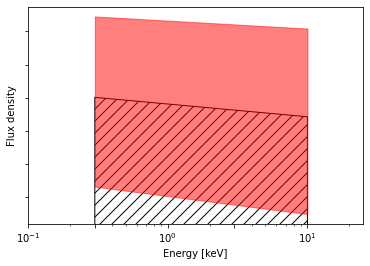

In [21]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density")

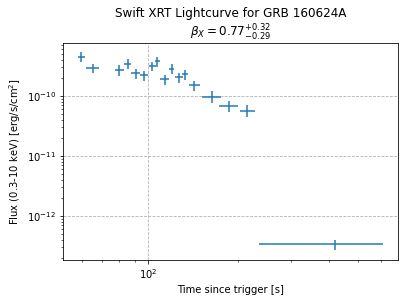

In [23]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gamma.minus,Gamma.plus))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")
plt.show()

In [124]:
xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
for i in sGRBs.index:
    GRB_ID = sGRBs.loc[i,"GRB"]
    
    try:
        Gamma = get_BetaX(GRB_ID,swift)
        fluxdata = XRT_lightcurve(GRB_ID,swift)
        xrt_data = xrt_data.append(fluxdata,ignore_index=True)

        sGRBs.loc[i,"Beta_X"] = Gamma.value - 1
        sGRBs.loc[i,"Beta_X_neg"] = Gamma.minus
        sGRBs.loc[i,"Beta_X_pos"] = Gamma.plus
        print(GRB_ID,"✓")
        
    except:
        print(GRB_ID,"✗")

210413B ✗
210323A ✓
210119A ✗
201221D ✓
201006A ✓
200907B ✓
200522A ✓
200411A ✓
191031D ✓
190627A ✓
190610A ✗
190427A ✗
190326A ✗
181123B ✓
180805A ✓
180727A ✓
180718A ✗
180715A ✗
180402A ✓
180204A ✓
170728A ✓
170524A ✓
170428A ✓
170325A ✗
170127B ✓
170112A ✗
161104A ✓
160927A ✓
160821B ✓
160726A ✗
160714A ✗
160624A ✓
160601A ✓
160525B ✓
160411A ✓
160408A ✓
151229A ✓
151228A ✗
151205B ✗
151127A ✓
150831A ✓
150728A ✓
150710A ✗
150423A ✓
150301A ✓
150120A ✓
150101B ✗
150101A ✓
141212A ✓
141205A ✗
140930B ✓
140903A ✓
140622A ✓
140611A ✗
140606A ✗
140516A ✓
140414A ✗
140402A ✗
140320A ✓
140129B ✓
131004A ✓
130912A ✓
130626A ✗
130603B ✓
130515A ✓
130313A ✗
121226A ✓
120804A ✓
120630A ✓
120521A ✓
120403A ✗
120305A ✓
120229A ✗
111126A ✗
111117A ✓
111020A ✓
110420B ✗
110112A ✓
101224A ✗
101219A ✓
101129A ✗
100724A ✓
100702A ✓
100628A ✗
100625A ✓
100206A ✓
100117A ✓
091117 ✗
091109B ✓
090815C ✗
090621B ✓
090515 ✓
090510 ✓
090426 ✓
090417A ✗
090305A ✗
081226A ✓
081101 ✗
081024A ✓
080919 ✓
080905

## Converting x-ray flux values to spectral flux densities

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [174]:
for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    if grb_id not in new_sGRBs["GRB"].values:
        continue
    beta = AsymmetricUncertainty(float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # convert 90% conf to 1-sigma
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # convert 90% conf to 1-sigma
    B = beta.value
    Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
    if B == 1:
        integral = np.log(10) - np.log(0.3)
    else:
        integral = (10**(1-B) - 0.3**(1-B))/(1-B)

    log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10)))

    dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
    dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))
    pos_err = np.sqrt(dfdF**2*Fx.plus**2 + dfdB**2*beta.plus**2)
    neg_err = np.sqrt(dfdF**2*Fx.minus**2 + dfdB**2*beta.minus**2)
    result = Fx.value*log_mean_energy**(-B)/integral
    spectral_flux = AsymmetricUncertainty(result,pos_err,neg_err) # erg/s/cm^2/keV
    spectral_flux *= 1e23/241797944177033445 # convert to Jy
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

<ipython-input-174-50e860eb3f6e>:17: RuntimeWarning: invalid value encountered in double_scalars
  dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
<ipython-input-174-50e860eb3f6e>:18: RuntimeWarning: invalid value encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))
<ipython-input-174-50e860eb3f6e>:18: RuntimeWarning: divide by zero encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))


In [175]:
for i in XRayData.index[::-1]: # add David's old data in the same format
    GRB = XRayData.loc[i,"GRB"][3:]
    if GRB not in xrt_data["GRB"].tolist():
        t = XRayData.loc[i,"Time"]
        tpos = tneg = XRayData.loc[i,"Exposure"]/2
        flux = XRayData.loc[i,"F_x"]/1000000 # uJy to Jy
        fluxpos = fluxneg = XRayData.loc[i,"e_F_x"]/1000000
        newrow = dict(zip(xrt_data.columns, [t,tpos,tneg,np.nan,np.nan,np.nan,GRB,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
        xrt_data = xrt_data.append(newrow, ignore_index=True)

{'Time': 3400000.0, 'Tpos': 7500.0, 'Tneg': 7500.0, 'Flux': nan, 'Fluxpos': nan, 'Fluxneg': nan, 'GRB': '150101B', 'SpecFlux': <code.uncertainty.AsymmetricUncertainty object at 0x0000021FC8DDD1F0>}
{'Time': 29000.0, 'Tpos': 2500.0, 'Tneg': 2500.0, 'Flux': nan, 'Fluxpos': nan, 'Fluxneg': nan, 'GRB': '141205A', 'SpecFlux': <code.uncertainty.AsymmetricUncertainty object at 0x0000021FC9385160>}
{'Time': 120000.0, 'Tpos': 25500.0, 'Tneg': 25500.0, 'Flux': nan, 'Fluxpos': nan, 'Fluxneg': nan, 'GRB': '141202A', 'SpecFlux': <code.uncertainty.AsymmetricUncertainty object at 0x0000021FC9785820>}
{'Time': 59000.0, 'Tpos': 1950.0, 'Tneg': 1950.0, 'Flux': nan, 'Fluxpos': nan, 'Fluxneg': nan, 'GRB': '140619B', 'SpecFlux': <code.uncertainty.AsymmetricUncertainty object at 0x0000021FC97B7FA0>}
{'Time': 4600.0, 'Tpos': 1200.0, 'Tneg': 1200.0, 'Flux': nan, 'Fluxpos': nan, 'Fluxneg': nan, 'GRB': '140606A', 'SpecFlux': <code.uncertainty.AsymmetricUncertainty object at 0x0000021FC8DDD250>}
{'Time': 41000.0

## Load new optical data

In [27]:
new_optical = pd.read_excel("./data/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical.drop(new_optical[new_optical["Magnitude"]=="spectroscopy only"].index,axis=0,inplace=True)
new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

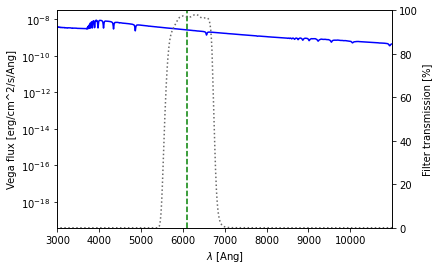

6100.363120460687

In [28]:
I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt")
rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
rprime_filter.columns = ["Wavelength","Transmission"]
rprime_filter["Wavelength"] *= 10

effective_wavelength(rprime_filter,show_plot=True)

## Correcting for extinction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [29]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

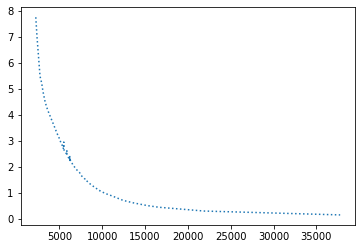

In [30]:
RbTable.sort_values(by="lambda_eff",inplace=True)
plt.plot(RbTable.lambda_eff, RbTable.R_b, ":")

In [31]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

## Converting optical magnitudes to spectral flux densities

In [32]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at F_nu = 3631 Jy

all_optical = new_optical.copy()

for i in OpticalData.index:
    GRB = OpticalData.loc[i,"GRB"]
    obs = OpticalData.loc[i,"Observatory"]
    inst = OpticalData.loc[i,"Instrument"]
    filt = OpticalData.loc[i,"Filter"]
    time = OpticalData.loc[i,"Time"]
    lambda_eff = OpticalData.loc[i,"Wavelength"]*10
    flux = OpticalData.loc[i,"F_o"]/1000000
    fluxpos = fluxneg = OpticalData.loc[i,"e_F_o"]/1000000
    newrow = dict(zip(all_optical.columns, [GRB,np.nan,obs,inst,filt,lambda_eff,time,np.nan,np.nan,"Fong",
                                            np.nan,np.nan,np.nan,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
    all_optical = all_optical.append(newrow, ignore_index=True)

## Putting it all together

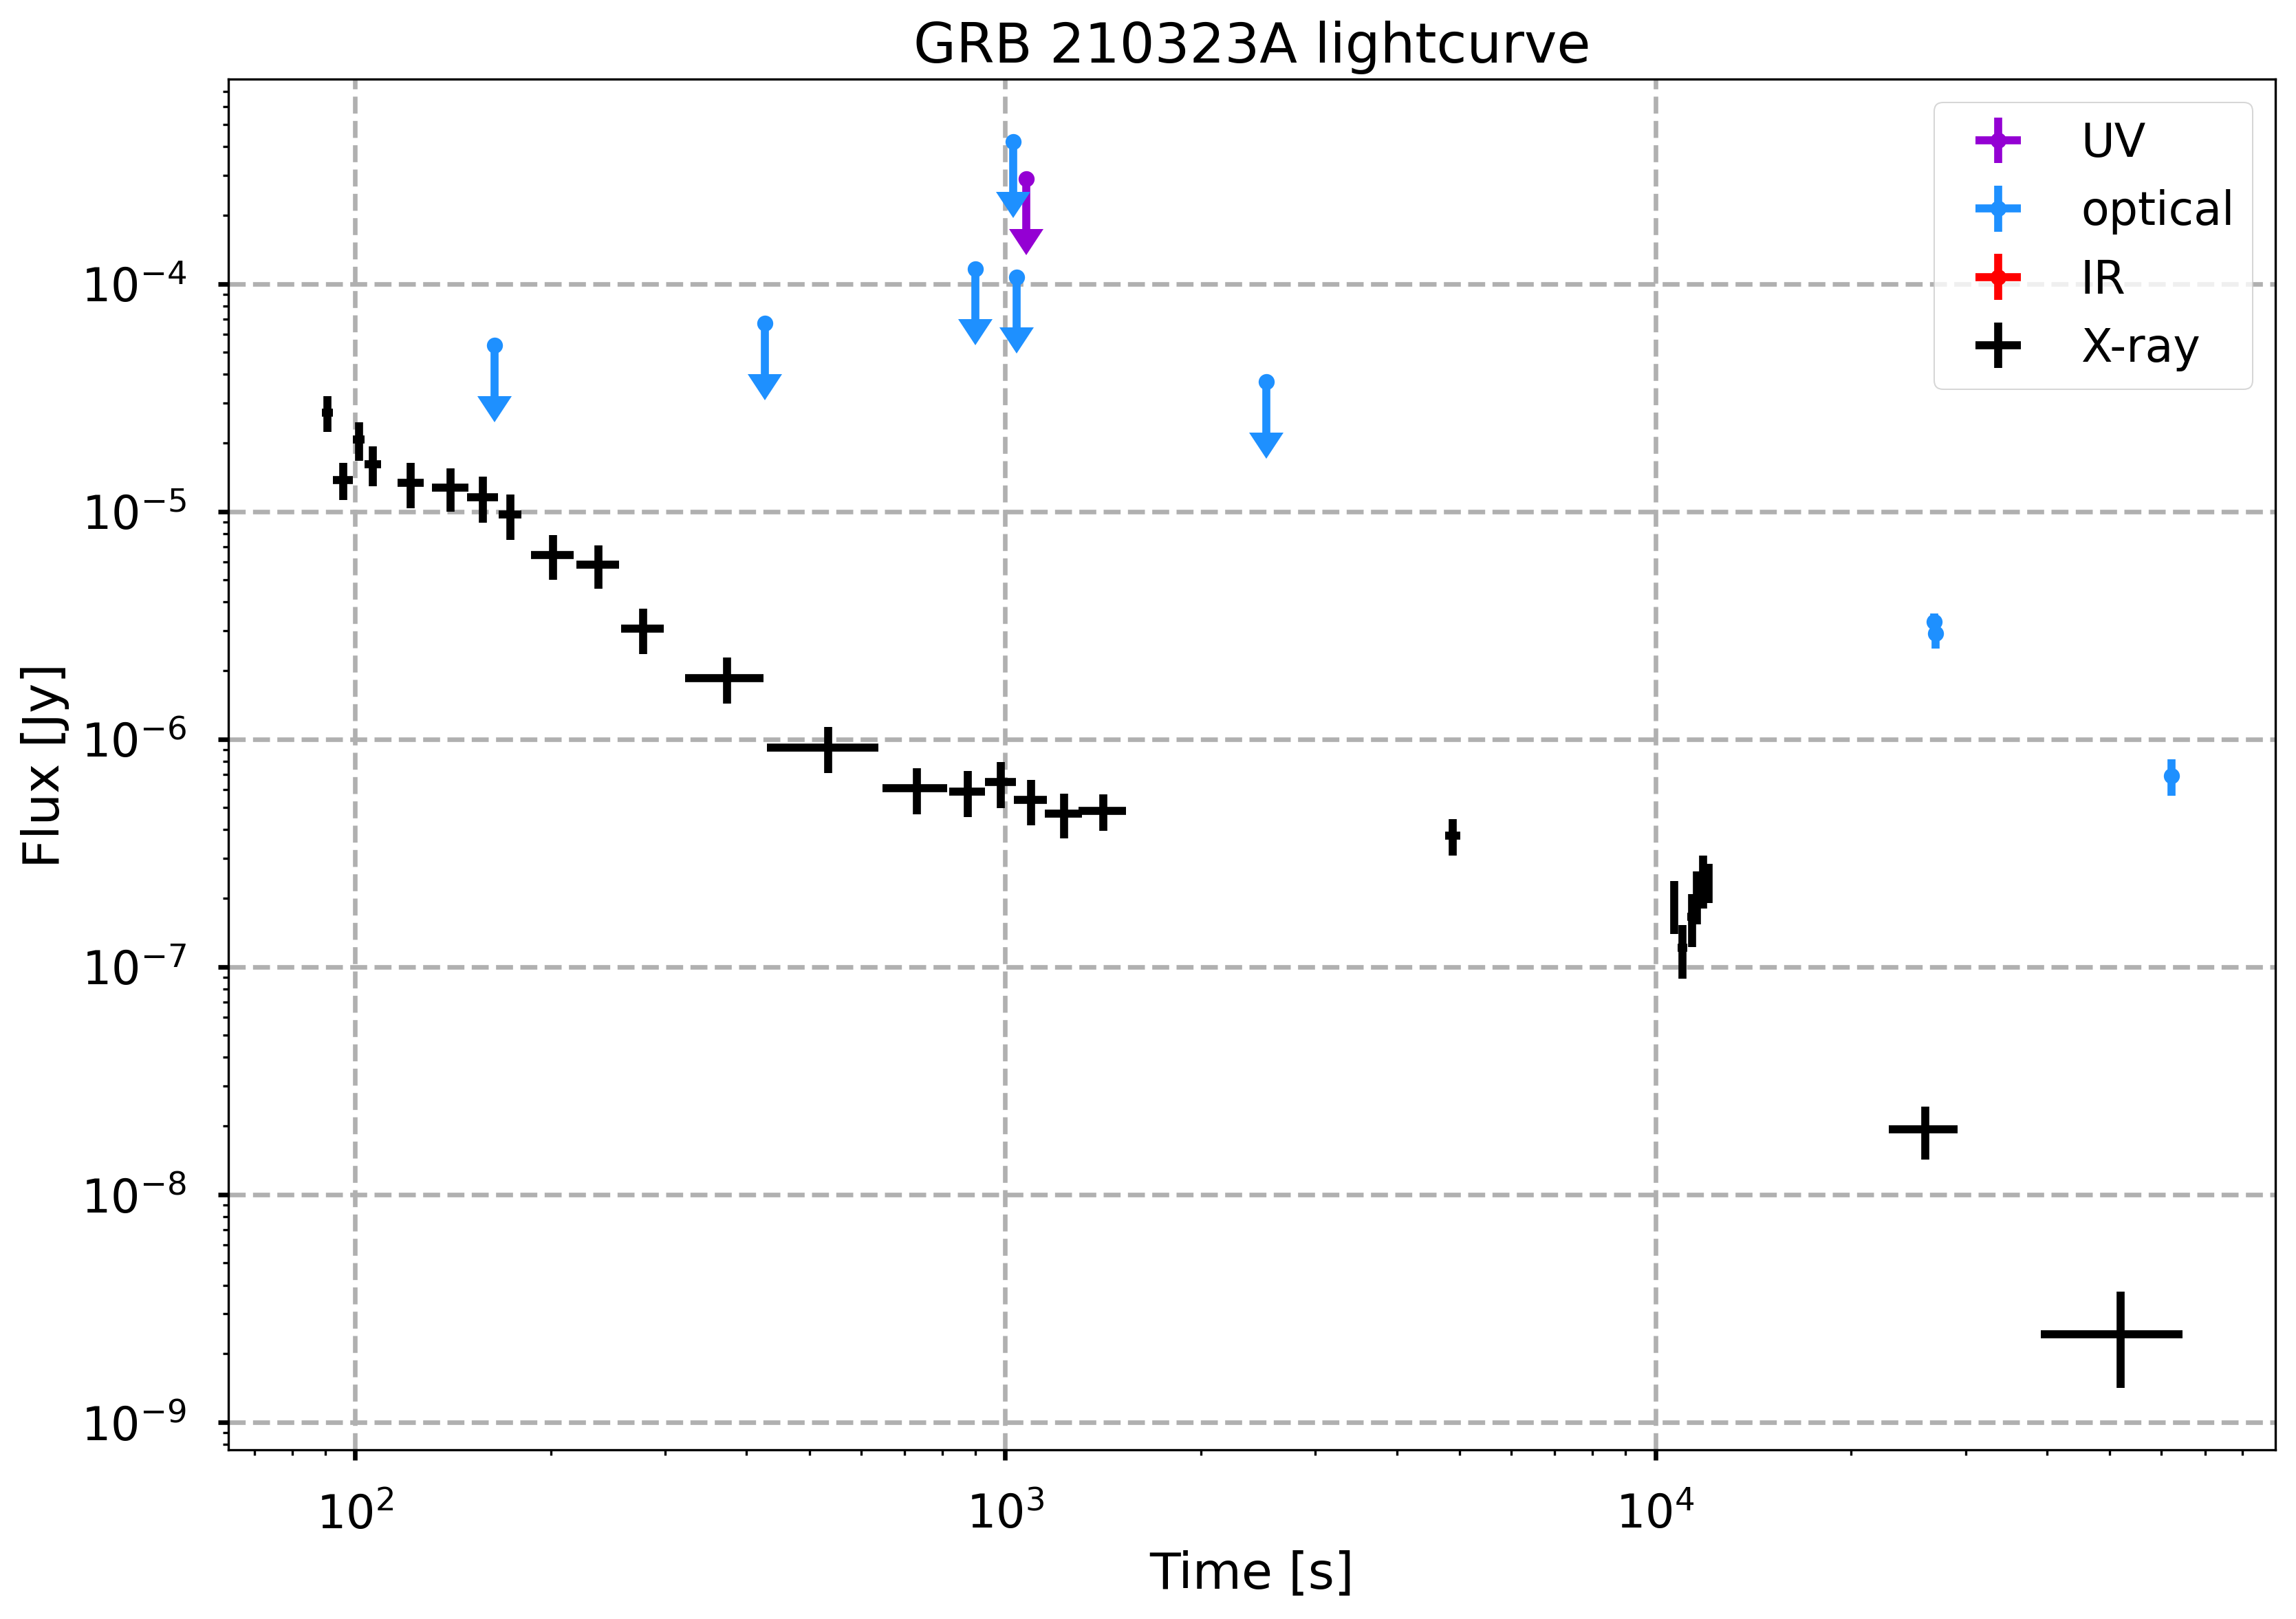

In [82]:
grb = "210323A"

fig, ax = plt.subplots(dpi=300)

subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()

subset.loc[:,"band"] = ["UV" if band<3000 else "IR" if band>8000 else None if pd.isna(band) else "optical" for band in subset["λ_eff"]]
colors = {"UV":"darkviolet","optical":"dodgerblue","IR":"red"}
for band,color in colors.items():
    subsubset = subset[subset["band"]==band]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
    ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                fmt=".",color=color,label=f"{band}",capsize=6,xerr=1,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]])

subset = xrt_data.loc[xrt_data["GRB"]==grb]
neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                      xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                      linestyle="",capthick=0,color="k",label="X-ray")

ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
ax.legend()
ax.grid(linestyle="--")

In [34]:
display(all_optical)
display(xrt_data)

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
0,210413B,1043009,GECKO,LOAO,B,4380.74,185459.217,20.78,inf,GCN 29825,0.010,0.035828,"20.78 (+inf, -0.0)","1.829605792911923e-05 (+0.0, -inf)"
1,210413B,1043009,GECKO,LOAO,V,5445.79,186062.483,20.347,inf,GCN 29825,0.010,0.027438,"20.347 (+inf, -0.0)","2.7052138348248542e-05 (+0.0, -inf)"
2,210413B,1043009,GECKO,LOAO,R,6414.20,186666.417,19.594,inf,GCN 29825,0.010,0.021711,"19.594 (+inf, -0.0)","5.384069702947088e-05 (+0.0, -inf)"
3,210413B,1043009,GECKO,LOAO,I,7978.80,187263.350,19.293,inf,GCN 29825,0.010,0.015373,"19.293 (+inf, -0.0)","7.062776069562384e-05 (+0.0, -inf)"
4,210323A,1038247,Gemini North,GMOS,r,6224.52,62208.000,24.6,0.2,GCN 29720,0.131,0.297948,24.6 ± 0.2,6.905664110119469e-07 ± 1.272070338974806e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,150101B,NaN,Gemini-S,GMOS,r,6330.00,925200.000,NaN,NaN,Fong,NaN,NaN,NaN,7.6e-07 ± 0.0
1070,150101B,NaN,TNG,NICS,J,12790.00,1256400.000,NaN,NaN,Fong,NaN,NaN,NaN,3.98e-06 ± 0.0
1071,150101B,NaN,VLT,HAWK-I,H,16200.00,1296000.000,NaN,NaN,Fong,NaN,NaN,NaN,1.4499999999999999e-06 ± 0.0
1072,150101B,NaN,Magellan/Baade,IMACS,r,6650.00,2498400.000,NaN,NaN,Fong,NaN,NaN,NaN,5.3e-07 ± 0.0


,Time,Tpos,Tneg,Flux,Fluxpos,Fluxneg,GRB,SpecFlux
0,90.691,1.772,-1.822,4.162478e-10,7.358302e-11,-7.358446e-11,210323A,2.723651204277404e-05 ± 4.904761274793357e-06
1,95.882,3.251,-3.419,2.102652e-10,3.838906e-11,-3.838998e-11,210323A,1.3758371770631024e-05 ± 2.5559588258795893e-06
2,101.302,2.183,-2.169,3.159472e-10,5.947158e-11,-5.947350e-11,210323A,2.0673502729757194e-05 ± 3.955634376822191e-06
3,106.615,2.334,-3.130,2.458731e-10,4.773577e-11,-4.773773e-11,210323A,1.6088318360241458e-05 ± 3.1719811063055207e-06
4,121.846,9.342,-5.702,2.036823e-10,4.575964e-11,-4.575964e-11,210323A,1.3327629993240761e-05 ± 3.0289737849755426e-06
...,...,...,...,...,...,...,...,...
1009,210000.000,2500.000,2500.000,NaN,NaN,NaN,050709,1.5e-09 ± 0.0
1010,140000.000,7500.000,7500.000,NaN,NaN,NaN,050709,1.9e-09 ± 1.3999999999999998e-10
1011,210000.000,25000.000,25000.000,NaN,NaN,NaN,050509B,8e-09 ± 0.0
1012,6200.000,1000.000,1000.000,NaN,NaN,NaN,050509B,2e-08 ± 0.0


## Match data points in time

In [103]:
max_dt = 0.2
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18 # xray frequency [m]
results = pd.DataFrame(columns=["GRB","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in all_optical.index: # for each optical data point
    t_o = all_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = all_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(all_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency [m]
    for i_x in xrt_data[xrt_data["GRB"]==all_optical.loc[i_o,"GRB"]].index: # for each x-ray data point on this GRB
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_o # time difference
        if dt <= max_dt: # if time separation is allowable
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox):
                results = results.append({"GRB":all_optical.loc[i_o,"GRB"], "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)
        else: # if data points don't match
            pass

In [104]:
# get the previously retreived x-ray spectral indices for comparison

all_beta_x = pd.concat((new_sGRBs[["GRB","Beta_X","Beta_X_pos","Beta_X_neg"]],BetaXData)) # table of all xray spectral indices
results = results.merge(all_beta_x,on="GRB",how="left") # match by GRB ID
results["B_x"] = [AsymmetricUncertainty(*results.loc[i,["Beta_X","Beta_X_pos","Beta_X_neg"]]) for i in results.index] # construct objects
results.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'],axis=1,inplace=True) # discard superfluous columns

# add flag columns for darkness by both methods
for i in results.index: # '<<' operator is overloaded for use with AsymmetricUncertainty class
    results.loc[i,"Jak_dark"] = (results.loc[i,"B_ox"] << 0.5)
    results.loc[i,"vdH_dark"] = (results.loc[i,"B_ox"] << results.loc[i,"B_x"]-0.5)

results.sort_values(by="GRB",ascending=False)

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
0,210323A,0.165115,4.816314e+14,6.905664110119469e-07 ± 1.272070338974806e-07,4.188080e+17,2.430646430740983e-09 ± 1.3082269147041803e-09,"0.8347169499806824 (+0.06743090287720507, -0.0...","0.72 (+0.2, -0.19)",False,False
18,210323A,0.085277,1.116903e+15,"0.000288885003598624 (+0.0, -inf)",4.188080e+17,6.461009692083274e-07 ± 1.4774318266204916e-07,"1.029691207614695 (+0.03853941200036465, -inf)","0.72 (+0.2, -0.19)",False,False
20,210323A,0.144464,1.116903e+15,"0.000288885003598624 (+0.0, -inf)",4.188080e+17,4.7009435119373687e-07 ± 1.0491056567996635e-07,"1.0833490900070264 (+0.037610434762944595, -inf)","0.72 (+0.2, -0.19)",False,False
21,210323A,0.128150,1.334915e+15,"nan (+nan, -nan)",4.188080e+17,6.075614710059527e-07 ± 1.3918878350877762e-07,"nan (+nan, -nan)","0.72 (+0.2, -0.19)",False,False
22,210323A,0.044666,1.334915e+15,"nan (+nan, -nan)",4.188080e+17,5.879375347613397e-07 ± 1.345750923708502e-07,"nan (+nan, -nan)","0.72 (+0.2, -0.19)",False,False
...,...,...,...,...,...,...,...,...,...,...
610,050709,0.034029,5.382270e+14,6.4e-07 ± 7e-08,4.188080e+17,1.1000000000000001e-09 ± 2.0000000000000002e-11,0.9563265188375428 ± 0.0166558198059755,1.24 ± 0.35,False,False
615,050709,0.027778,4.626427e+14,1.17e-06 ± 2.6e-07,4.188080e+17,1.5e-09 ± 0.0,0.9781265680324264 ± 0.03264031625339155,1.24 ± 0.35,False,False
616,050709,0.018359,5.382270e+14,3.6e-07 ± 0.0,4.188080e+17,5.9e-09 ± 0.0,0.617578667886267 ± 0.0,1.24 ± 0.35,False,False
609,050709,0.143791,4.626427e+14,2.34e-06 ± 1.2e-07,4.188080e+17,1.9e-09 ± 1.3999999999999998e-10,1.0452158922222696 ± 0.013186002471900944,1.24 ± 0.35,False,False


In [105]:
dark = results.loc[results["Jak_dark"] | results["vdH_dark"],:]
for GRB in dark["GRB"].unique():
    print(GRB,dark["GRB"].tolist().count(GRB))

210323A 3
200411A 3
191031D 1
181123B 1
180727A 1
180204A 3
160927A 1
160821B 26
160624A 4
151229A 10
150831A 12
150423A 1
060121 56
060313 23
070707 2
070714B 1
080503 3
100117A 1
111020A 3
120804A 2
130603B 11
130912A 7
150120A 1


In [106]:
# only accept the closest in time for each GRB
close_times = dark.copy()
for grb_id in dark["GRB"].unique():
    working = dark[dark["GRB"]==grb_id]
    closest_time = working["dt%"].min()
    close_times.drop(working[working["dt%"] != closest_time].index, axis=0, inplace=True)
    
darkest_times = dark.copy()
for grb_id in dark["GRB"].unique():
    working = dark[dark["GRB"]==grb_id]
    darkest_beta = working["B_ox"].min()
    darkest_times.drop(working[working["B_ox"] != darkest_beta].index, axis=0, inplace=True)

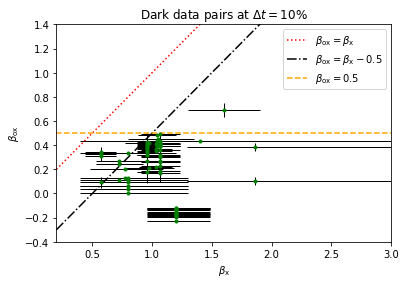

In [40]:
b_ox = [b.value for b in dark["B_ox"]]
oxplus = [b.plus for b in dark["B_ox"]]
oxminus = [b.minus for b in dark["B_ox"]]
b_x = [b.value for b in dark["B_x"]]
xplus = [b.plus for b in dark["B_x"]]
xminus = [b.minus for b in dark["B_x"]]
bursts = [grb for grb in dark["GRB"]]
plt.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],linestyle="",marker=".",
             mfc="g",mec="g",ecolor="k",elinewidth=1,capthick=1)
x = np.linspace(0.2,3,50)
y = np.linspace(-.4,1.4,50)
plt.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
plt.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
plt.plot(x,[.5]*len(x),linestyle="--",color="orange",label=r"$\beta_\mathrm{ox}=0.5$")
plt.xlim(.2,3)
plt.xlabel(r"$\beta_\mathrm{x}$")
plt.ylim(-.4,1.4)
plt.ylabel(r"$\beta_\mathrm{ox}$")
plt.title("Dark data pairs at $\Delta t=10\%$")
plt.legend()
plt.show()

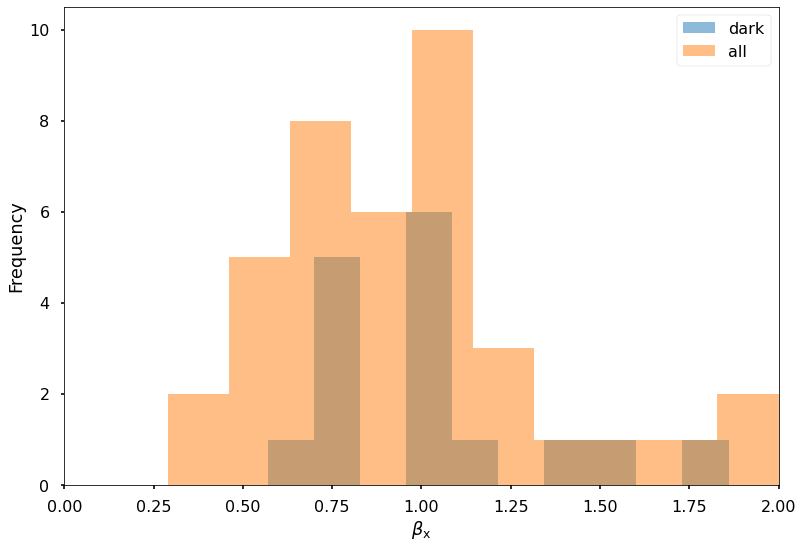

In [90]:
pd.Series([bx.value for bx in dark.drop_duplicates("GRB")["B_x"]]).plot.hist(label="dark",alpha=.5,bins=10)
pd.Series([bx.value for bx in results.drop_duplicates("GRB")["B_x"]]).plot.hist(label="all",alpha=.5,bins=10)
plt.xlim(0,2)
#plt.gca().set_yticklabels([])
plt.xlabel(r"$\beta_\mathrm{x}$")
plt.legend()
plt.show()

GRB                                                 160624A
dt%                                               0.0742895
nu_o                                            7.71532e+14
F_o                     2.2469077263974652e-05 (+0.0, -inf)
nu_x                                            4.18808e+17
F_x           6.43563651729827e-06 ± 1.4683568734923836e-06
B_ox        0.1985597727235074 (+0.03610621145682231, -inf)
B_x                                     0.77 (+0.32, -0.29)
Jak_dark                                               True
vdH_dark                                              False
Name: 228, dtype: object

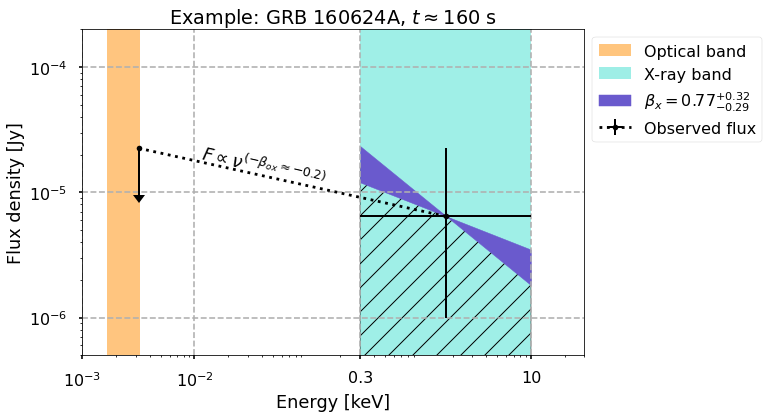

In [41]:
display(results[results["GRB"]=="160624A"].iloc[1,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)

E_o = results.loc[228,"nu_o"]*6.62607015e-34/1.6021773E-16
E_x = results.loc[228,"nu_x"]*6.62607015e-34/1.6021773E-16
F_o = results.loc[228,"F_o"]
F_x = results.loc[228,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x],[F_o.value,F_x.value],xerr=[(0,E_x-0.3),(0,10-E_x)],
             yerr=[(0.000013,F_x.value-1e-6),(0,F_o.value-F_x.value)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label=r"$\beta_x=0.77_{-0.29}^{+0.32}$")
plt.text(1.1e-2,1.1e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.2})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(1e-3,30)
plt.ylim(5e-7,2e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 160624A, $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./products/160624A.png",bbox_inches="tight",dpi=300)